<a href="https://colab.research.google.com/github/samuel0922/my_ex/blob/main/%5BEX06%5DTRANSFORMER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [EX06]TRANSFORMER


## 개요 : 멋진 작사가 만들기
데이터를 받아서 노래 가사를 생성해 주는 모델을 만들어 봄.

## 진행 순서
1. 환경 준비
2. 데이터 준비
3. 데이터 정제
4. 토크나이징
5. 모델 설계
6. 모델 학습
7. 모델 평가

[ 루브릭 ]<br><br>
[ 회고 ]

### STEP 0. 환경 준비하기

In [ ]:
# 모듈 임포트

import os, re  # re 정규표현식
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

### STEP 1. 데이터 준비하기

In [ ]:
# 구글 드라이브에서 파일 불러오기 위해 마운트해 줌

import sys
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### STEP 1. 1 데이터 문장 단위로 읽어오기

In [ ]:
# 구글 드라이브에서 파일 불러오기
# 파일을 읽기모드로 열고
# 라인 단위로 끊어서 list 형태로 읽어옵니다.

import glob

txt_file_path = '/content/drive/MyDrive'+'/aiffel/lyricist/data/lyrics/*'
txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)


print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])


데이터 크기: 187088
Examples:
 ["Let's stay together I, I'm I'm so in love with you", 'Whatever you want to do', 'Is all right with me']


##### =>
* 해당 데이터에는 불필요한 데이터(이 데이터는 대본이므로 화자, 공백)가 포함됨 -> 제거
* 해당 데이를 제거할 기준을 찾아봄

> * 화자 : 문장 뒤에 :로 끝남
> * 공백 : 길이가 0

### STEP 1.2 데이터 정제하기

1) 문장을 일정한 기준으로 쪼갬

통상 많이 쓰는 기준. 띄어쓰기를 기준
단, 문장부호, 대소문자, 특수문자 등 처리가 필요함

1. 대소문자 : First와 first를 다른 단어로 인식
2. " " : 문장이 각 단어에 " "를 기준으로 분리됨. "Hi,""my",.."John"
3. 특수문자 : ten-year-old boy에서 ten-year-old를 한 단어로 인식
##### => 처리 => 정규표현식 이용해 필터링

3. 모든 문자들을 소문자로 변환
2. 문장 부호 양쪽에 공백 추가
3. 특수문자들 모두 제거

2) 정제된 문장을 모음

In [ ]:
# 공백 문장 길이 검사 => 길이 0이면 제외

for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue   # 길이가 0인 문장은 건너뜁니다.
    if sentence[-1] == ":": continue  # 문장의 끝이 : 인 문장은 건너뜁니다.

    if idx > 9: break   # 일단 문장 10개만 확인해 볼 겁니다.
        
    print(sentence)

Let's stay together I, I'm I'm so in love with you
Whatever you want to do
Is all right with me
Cause you make me feel so brand new
And I want to spend my life with you Let me say that since, baby, since we've been together
Loving you forever
Is what I need
Let me, be the one you come running to
I'll never be untrue Oh baby
Let's, let's stay together (gether)


In [ ]:
# 입력된 문장을 정제하는 함수 정의 using 정규표현식

#     1. 소문자로 바꾸고 lower(), 양쪽 공백을 지웁니다 strip()
#     2. 특수문자 양쪽에 공백을 넣고
#     3. 여러개의 공백은 하나의 공백으로 바꿉니다
#     4. a-zA-Z?.!,¿가 아닌(대,소문자, 마침표, 컴마, 물음표, 느낌표, 역물음표 제외) 모든 문자를 하나의 공백으로 바꿉니다
#     5. 다시 양쪽 공백을 지웁니다
#     6. 문장 시작에는 <start>, 끝에는 <end>를 추가합니다

# 정규표현식
# 문자열 앞에 r(raq string)이 붙으면 해당 문자열이 구성(포함)된 그대로 문자열을 반환
# sub : 주어진 문자열에서 일치하는 모든 패턴을 replace

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1 공백을 제거
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2 첫번째 하부식을 기준으로 좌우에 공백으로 대체
    sentence = re.sub(r'[" "]+', " ", sentence) # 3 공백이 반복(+)되는 것, 즉 여러개 이어진 공백을 (하나의) 공백" "으로 대체 
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4 소문자 대문자 구두점 
    sentence = sentence.strip() # 5 다시 양쪽 공백 제거
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

# 이 문장이 어떻게 필터링되는지 확인해 보세요.
print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>


In [ ]:
# 말뭉치 corpus를 선언해 주고, 여기에 정제된 문장을 모음

corpus = []

for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다 => '공백'이거나, '화자'가 표시된 문장.
    if len(sentence) == 0: continue  # => '공백'인 문장
    if sentence[-1] == ":": continue  # => '화자'가 표시된 문장
    
    # 정제를 하고 객체에 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    
    #길이 15안되는 문장만 가려서 넣어보기
    if len(preprocessed_sentence.split()) > 15: continue

    corpus.append(preprocessed_sentence) # 정제된 문장을 corpus객체에 추가해 줌.
        
# 정제된 결과를 10개만 확인해보죠
corpus[:10]

['<start> whatever you want to do <end>',
 '<start> is all right with me <end>',
 '<start> cause you make me feel so brand new <end>',
 '<start> loving you forever <end>',
 '<start> is what i need <end>',
 '<start> let me , be the one you come running to <end>',
 '<start> i ll never be untrue oh baby <end>',
 '<start> let s , let s stay together gether <end>',
 '<start> lovin you whether , whether <end>',
 '<start> times are good or bad , happy or sad <end>']

---
지금부터 하는 작업은 => 기계가 소화시킬 수 있게 데이터를 만들어 주는 것. 잘게 쪼개서 단어사전을 만들되 기계가 알아듣게 숫자로 변환하는 과정 => 텐서플로우에서 제공하는 모듈을 활용함
tf.keras.preprocessing.text.Tokenizer가 다 해 줌 ^^  할 게 없네? 

---
## STEP 2. Tokenizing
텍스트 생성 모델에도 단어 사전을 만들어야 함.
Tokenizie( )가 기본적인 Filter 옵션을 제공하지만 별도의 전처리를
통해 더 많은 정제작업을 수행하는 게 좋음.

## STEP 3. Vetorizing : tensor(숫자로 변환된 단어사전, 2차원 행렬)
단, 사전을 숫자로 변환해서 만듦


In [ ]:
# 토큰화 할 때 텐서플로우의 Tokenizer와 pad_sequences를 사용합니다
# 더 잘 알기 위해 아래 문서들을 참고하면 좋습니다
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences

def tokenize(corpus):

    # 12000단어를 기억할 수 있는 tokenizer(단어장)를 만들겁니다
    # 우리는 이미 문장을 정제했으니 filters가 필요없어요
    # 12000단어에 포함되지 못한 단어는 '<unk>'로 바꿀거에요

    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, 
        filters=' ',
        oov_token="<unk>" # unknow 토큰 처리하는 토큰. 12000단어만 기억되므로 
    )

    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    # texts_to_sequences를 사용하기 전에 해줘야 함
    tokenizer.fit_on_texts(corpus)  # 텍스트 목록을 기반으로 내부 어휘를 업데이트함
    
    # 준비한 tokenizer를 이용해 corpus를 Tensor(정수로 변환된 말뭉치)로 변환합니다
    tensor = tokenizer.texts_to_sequences(corpus)   # 텍스트의 각 텍스트를 일련의 정수로 변환함
    
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤(디폴트)에 패딩(디폴트는 0)을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    # max_len 가장 긴 문장을 기준으로 시퀀스 길이(토큰의 개수)를 맞춰줌. 
    # 디폴트는 None이지만 이번에는 15
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=20)  
    
    print(tensor, tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[  2 570   7 ...   0   0   0]
 [  2  26  25 ...   0   0   0]
 [  2  66   7 ...   0   0   0]
 ...
 [  2  30  19 ...   0   0   0]
 [  2 344  19 ...   0   0   0]
 [  2  41 129 ...   0   0   0]] <keras_preprocessing.text.Tokenizer object at 0x7f06320984d0>


In [ ]:
# 생성된 데이터 확인 => tensor는 tokenizer에 구축된 단어 사전의 인덱스임.
# 모든 행이 2로 시작??? 모두 같은 값인 2번 인덱스 => <start>

print(tensor[:3, :10])

[[  2 570   7  64  10  48   3   0   0   0]
 [  2  26  25  87  30  12   3   0   0   0]
 [  2  66   7  72  12 106  31 809 153   3]]


In [ ]:
# 토크나이저에 구축된 단어 사전 확인

for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : ,
6 : the
7 : you
8 : and
9 : a
10 : to


## STEP 4. 데이터 분리
#### tensor에서 처음과 끝 토큰을 잘라내서 소스 문장과 타켓 문장 생성



In [ ]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>(길이를 맞추기 위해 채웠던 즉, 0)일 가능성이 높습니다.
src_input = tensor[:, :-1]

# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[  2 570   7  64  10  48   3   0   0   0   0   0   0   0   0   0   0   0
   0]
[570   7  64  10  48   3   0   0   0   0   0   0   0   0   0   0   0   0
   0]


In [ ]:
# 평가 데이터셋 분리
# 훈련 데이터와 평가 데이터를 분리해 줌 => 20%를 평가 데이터로 분리

X_train, X_val, y_train, y_val = train_test_split(src_input, tgt_input, test_size=0.2, random_state=2020)

### =>
##### src 데이터 
##### tgt 데이터 : 왼쪽으로 한 칸 시프트 한 형태 <= Start만 잘라낸 거니까
---
#### 데이터 객체 생성
* 지금까지 데이터셋은 model.fit(x_train, y_train) 형태로 Numpy Array 데이터셋을 생성해 model에 제공하는 형태의 학습을 많이 진행해옴

* 여기서는 텐서플로우를 활용할 경우 텐서로 생성된 데이터를 이용해 tf.data.Dataset객체를 생성하는 방법을 흔히 사용
=> 데이터 입력 파이프라인을 통한 속도 개선 및 각종 편의 기능 제공함.
* 앞에서 데이터셋을 tensor 형태로 생성해 뒀으므로 from_tensor_slices() 메소드를 이용해 tf.data.Dataset 객체를 생성함.

In [ ]:
# 데이터 객체 생성

BUFFER_SIZE = len(src_input) # 앞에서 압력소스를 만든 것의 길이로 버퍼사이즈를 정함
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE  # epoch당 스텝수는 버퍼 사이즈를 배치사이즈로 나눠준 값. // 은 int로.

 # tokenizer가 구축한 단어사전 내 12000개와, 여기 포함되지 않은 0:<pad>를 포함하여 12001개
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듭니다
# 데이터셋에 대해서는 아래 문서를 참고하세요
# 자세히 알아둘수록 도움이 많이 되는 중요한 문서입니다
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
# 소스데이터와 타깃데이터를 받아서 잘라주고 -> 섞어주고 -> batch를 구성해 줌
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

print(X_train.shape)
print(y_train.shape)
train_dataset

(124810, 19)
(124810, 19)


<BatchDataset element_spec=(TensorSpec(shape=(256, 19), dtype=tf.int32, name=None), TensorSpec(shape=(256, 19), dtype=tf.int32, name=None))>

In [ ]:
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

print(X_val.shape)
print(y_val.shape)
val_dataset

(31203, 19)
(31203, 19)


<BatchDataset element_spec=(TensorSpec(shape=(256, 19), dtype=tf.int32, name=None), TensorSpec(shape=(256, 19), dtype=tf.int32, name=None))>

### * 데이터 전처리, 생성 과정
1. corpus 생성 <-- 정규표현식 이용
2. corpus를 텐서로 변환 <-- tf.keras.preprocessing.text.Tokenizer 이용해
3. corpus 텐서를 tf.data.Dataset객체로 변환 <-- tf.data.Dataset.from_tensor_slices()를 이용

## STEP 5. 모델 만들기
tf.keras.Model을 Subclassing하는 방식
##### 모델 구성 : 
* Embedding Layer 1개  입력층
* LSTM Layer      2개  은닉층
* Dense Layer     1개  출력층

##### Embedding layer 2개 
- 단어 사전의 인덱스 값을 해당 인덱스 번째의 워드 벡터로 바꿔줌 
=> 이 워드 벡터는 의미 벡터 공간에서 단어의 추상적 표현(representation)으로 사용됨.
- embedding_size는 워드 벡터의 차원수, 즉 단어가 추상적으로 표현되는 크기
- 만일 크기가 2(차원)이면 =>
* 차갑다 : [0.0, 1.0]
* 뜨겁다 : [1.0, 0.0]
* 미지근하다 : [0.5, 0.5] 로 구분 가능
=> 이번 경우엔 256이 적당함
##### LSTM layer 2개
- hidden_size : hidden state의 차원 수. 모델에 얼마나 많은 일꾼을 둘 것인가? 
- 일꾼들은 모두 같은 데이터를 보고 각자의 생각을 가지는데, 충분한 데이터가 주어지지 않으면 배가 산으로 갈 뿐
=> 이번 경우엔 1024가 적당함 
##### Dense layer 1개

In [ ]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()

        # Embedding Layer : 입력텐서에 들어있는 단어사전의 인덱스 값을 해당 인덱스 번째의 워드 벡터로 변환
        # => 의미 벡터 공간에서 단어의 추상적 표현으로 사용됨    
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

# 모델을 생성하는데 필요한 세 가지 인자를 설정해 줌.
    
# vocab_size  <= 앞에서 만들어놓은 토크나이저에서 단어수에 1을 더해줌
embedding_size = 1024  # 워드 벡터의 차원수. 즉, 단어가 추상적으로 푷련되는 크기
hidden_size = 2048  # LSTM 레이어의 hidden state의 차원수. 얼마나 많은 일꾼을 둘 것인가?
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [ ]:
# 모델을 동작을 확인해 보기 위해 데어터 한 배치만 넣어서 테스트 해 봄

# 데이터셋에서 데이터 한 배치만 불러오는 방법입니다. dataset.take(배치 개수)
# 한 배치(256개 문장) 불러와서 인풋샘플과 타킷샘플에 할당해 줌
for src_sample, tgt_sample in train_dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(src_sample)

<tf.Tensor: shape=(256, 19, 12001), dtype=float32, numpy=
array([[[-1.05303545e-04,  1.72075903e-04, -2.09672157e-06, ...,
         -3.28311522e-04,  2.83458969e-04, -4.43515397e-04],
        [ 3.49168724e-04, -2.34414649e-04,  1.42330100e-04, ...,
         -5.17770008e-04,  1.42110193e-05, -1.06304954e-03],
        [ 4.27029474e-04, -3.73493502e-04,  1.31976805e-04, ...,
         -3.07864044e-04, -1.19801836e-04, -1.05743518e-03],
        ...,
        [ 2.02151597e-03, -5.60002029e-03,  1.55768695e-03, ...,
         -1.97599735e-03,  2.11173226e-03, -4.07065032e-03],
        [ 2.32134014e-03, -5.74400602e-03,  1.52115314e-03, ...,
         -2.07251823e-03,  2.19784002e-03, -4.03749384e-03],
        [ 2.58086063e-03, -5.81248850e-03,  1.47181679e-03, ...,
         -2.11967342e-03,  2.26741703e-03, -3.96564417e-03]],

       [[-1.05303545e-04,  1.72075903e-04, -2.09672157e-06, ...,
         -3.28311522e-04,  2.83458969e-04, -4.43515397e-04],
        [-2.60730129e-04, -3.11958371e-04, -1

##### => 모델을 실행시키면 출력에서 tensor의 형태를 보면 3차원 행렬(256, 346, 12001)임

> 256 : 이전 스텝에서 지정한 배치 사이즈 즉, 한 배치에 해당하는 문장 개수
> 346 : LSTM은 자신에게 입력된 시퀀스의 길이(입력 데이터의 개수)만큼 동일한 길이의 시퀀스를 출력함. 
<= tf.keras.layers.LSTM(hidden_size, return_sequences=True)로 호출한 LSTM레이어에서 
return_sequences=True라고 지정했으므로. 
만일 False로 설정하면 LSTM레이어는 1개의 벡터만 출력<br>
346은 데이터를 입력받을 때 알게 됨 => 데아터셋의 max_len이 20으로 맞춰져 있었던 것.
2. model.build()가 자동으로 호출됨.


* 파라미터 사이즈 : 22million

* Output Shape은 알려주지 않음 <== 그런데 문제는, 우리의 모델은 입력 데이터의 시퀀스 길이가 얼마인지 모른다는 점입니다. 모델을 만들면서 알려준 적도 없습니다. 그럼 20은 언제 알게된 것일까요? 네, 그렇습니다. 데이터를 입력받으면서 비로소 알게 된 것입니다. 우리 데이터셋의 max_len이 20으로 맞춰져 있었던 것입니다.

우리가 궁금했던 Output Shape를 정확하게 알려주지 않습니다. 바로 위에서 설명한 이유 때문입니다. 우리의 모델은 입력 시퀀스의 길이를 모르기 때문에 Output Shape를 특정할 수 없는 것입니다.



In [ ]:
model.summary()

Model: "text_generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  12289024  
                                                                 
 lstm (LSTM)                 multiple                  25174016  
                                                                 
 lstm_1 (LSTM)               multiple                  33562624  
                                                                 
 dense (Dense)               multiple                  24590049  
                                                                 
Total params: 95,615,713
Trainable params: 95,615,713
Non-trainable params: 0
_________________________________________________________________


##### => Output의 형태를 알려주지 않음 <= 모델이 시퀀스가 입력되기 전까지는 입력 시퀀스의 길이를 모르기 때문에 출력 형태를 특정할 수 없기 때문. 단, 파라미터 사이즈는 측정됨.
---

## STEP 6. 모델 학습
* optimizer와 loss등은 차차 배웁니다<br>
* 혹시 미리 알고 싶다면 아래 문서를 참고하세요<br>
* https://www.tensorflow.org/api_docs/python/tf/keras/optimizers<br>
* https://www.tensorflow.org/api_docs/python/tf/keras/losses
* 양이 상당히 많은 편이니 지금 보는 것은 추천하지 않습니다<br>


In [ ]:
# 옵티마이저는 Adam()으로 설정
# 코스트함수를 SparseCategoricalCrossentropy로 해서 loss에 할당해 줌

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

# 모델을 옵티마이저와 로스를 인자로 해 컴파일 해 줌
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

# 모델을 데이터셋을 넣고 EPOCH을 7으로 지정해 학습시킴
history = model.fit(train_dataset, epochs=7, batch_size=256, validation_data=val_dataset, verbose=1)

Epoch 1/7
487/487 [==============================] - 190s 386ms/step - loss: 2.3897 - accuracy: 0.6372 - val_loss: 2.1215 - val_accuracy: 0.6558
Epoch 2/7
487/487 [==============================] - 188s 386ms/step - loss: 1.9908 - accuracy: 0.6651 - val_loss: 1.9372 - val_accuracy: 0.6727
Epoch 3/7
487/487 [==============================] - 188s 386ms/step - loss: 1.7546 - accuracy: 0.6865 - val_loss: 1.7995 - val_accuracy: 0.6900
Epoch 4/7
487/487 [==============================] - 188s 386ms/step - loss: 1.5226 - accuracy: 0.7143 - val_loss: 1.6986 - val_accuracy: 0.7079
Epoch 5/7
487/487 [==============================] - 188s 386ms/step - loss: 1.3023 - accuracy: 0.7472 - val_loss: 1.6249 - val_accuracy: 0.7245
Epoch 6/7
487/487 [==============================] - 188s 386ms/step - loss: 1.1087 - accuracy: 0.7817 - val_loss: 1.5799 - val_accuracy: 0.7382
Epoch 7/7
487/487 [==============================] - 188s 386ms/step - loss: 0.9546 - accuracy: 0.8123 - val_loss: 1.5609 - val_ac

### 1st Try : 중간 컷

Epoch 1/30
686/686 [==============================] - 406s 588ms/step - loss: 3.2615 - accuracy: 0.4839 - val_loss: 2.7832 - val_accuracy: 0.5204
Epoch 2/30
686/686 [==============================] - 415s 605ms/step - loss: 2.6567 - accuracy: 0.5358 - val_loss: 2.3049 - val_accuracy: 0.5697
Epoch 3/30
686/686 [==============================] - 416s 606ms/step - loss: 2.2501 - accuracy: 0.5826 - val_loss: 1.8881 - val_accuracy: 0.6306
Epoch 4/30
686/686 [==============================] - 416s 607ms/step - loss: 1.8736 - accuracy: 0.6375 - val_loss: 1.5362 - val_accuracy: 0.6970
Epoch 5/30
686/686 [==============================] - 416s 607ms/step - loss: 1.5474 - accuracy: 0.6945 - val_loss: 1.2647 - val_accuracy: 0.7518
Epoch 6/30
334/686 [=============>................] - ETA: 3:18 - loss: 1.2749 - accuracy: 0.7482

### 2nd Try 

Epoch 1/7
686/686 [==============================] - 383s 554ms/step - loss: 85.8792 - accuracy: 0.3962 - val_loss: 74.9644 - val_accuracy: 0.3999
Epoch 2/7
686/686 [==============================] - 380s 554ms/step - loss: 68.7130 - accuracy: 0.4035 - val_loss: 63.4150 - val_accuracy: 0.4103
Epoch 3/7
686/686 [==============================] - 381s 555ms/step - loss: 60.1378 - accuracy: 0.4104 - val_loss: 56.9455 - val_accuracy: 0.4136
Epoch 4/7
686/686 [==============================] - 380s 554ms/step - loss: 54.5875 - accuracy: 0.4130 - val_loss: 52.0625 - val_accuracy: 0.4165
Epoch 5/7
686/686 [==============================] - 380s 554ms/step - loss: 50.3365 - accuracy: 0.4151 - val_loss: 48.4747 - val_accuracy: 0.4162
Epoch 6/7
686/686 [==============================] - 381s 555ms/step - loss: 47.2305 - accuracy: 0.4161 - val_loss: 45.7969 - val_accuracy: 0.4191
Epoch 7/7
686/686 [==============================] - 380s 554ms/step - loss: 44.6661 - accuracy: 0.4183 - val_loss: 43.2982 - val_accuracy: 0.4213

### 3rd Try
Epoch 1/20
686/686 [==============================] - 223s 319ms/step - loss: 3.2769 - accuracy: 0.4828 - val_loss: 2.7997 - val_accuracy: 0.5191
Epoch 2/20
686/686 [==============================] - 218s 318ms/step - loss: 2.6759 - accuracy: 0.5336 - val_loss: 2.3431 - val_accuracy: 0.5659
Epoch 3/20
686/686 [==============================] - 218s 318ms/step - loss: 2.2861 - accuracy: 0.5779 - val_loss: 1.9360 - val_accuracy: 0.6242
Epoch 4/20
686/686 [==============================] - 218s 318ms/step - loss: 1.9220 - accuracy: 0.6297 - val_loss: 1.5849 - val_accuracy: 0.6879
Epoch 5/20
686/686 [==============================] - 218s 318ms/step - loss: 1.6050 - accuracy: 0.6837 - val_loss: 1.3078 - val_accuracy: 0.7440
Epoch 6/20
686/686 [==============================] - 218s 318ms/step - loss: 1.3405 - accuracy: 0.7343 - val_loss: 1.1168 - val_accuracy: 0.7830
Epoch 7/20
686/686 [==============================] - 218s 318ms/step - loss: 1.1519 - accuracy: 0.7734 - val_loss: 0.9939 - val_accuracy: 0.8084
Epoch 8/20
686/686 [==============================] - 218s 318ms/step - loss: 1.0336 - accuracy: 0.7995 - val_loss: 0.9246 - val_accuracy: 0.8215
Epoch 9/20
686/686 [==============================] - 218s 318ms/step - loss: 0.9690 - accuracy: 0.8130 - val_loss: 0.8912 - val_accuracy: 0.8272
Epoch 10/20
686/686 [==============================] - 218s 317ms/step - loss: 0.9375 - accuracy: 0.8189 - val_loss: 0.8746 - val_accuracy: 0.8292
Epoch 11/20
686/686 [==============================] - 218s 317ms/step - loss: 0.9220 - accuracy: 0.8212 - val_loss: 0.8658 - val_accuracy: 0.8302
Epoch 12/20
686/686 [==============================] - 218s 317ms/step - loss: 0.9130 - accuracy: 0.8221 - val_loss: 0.8609 - val_accuracy: 0.8308
Epoch 13/20
686/686 [==============================] - 218s 317ms/step - loss: 0.9074 - accuracy: 0.8223 - val_loss: 0.8561 - val_accuracy: 0.8303
Epoch 14/20
686/686 [==============================] - 218s 317ms/step - loss: 0.9017 - accuracy: 0.8228 - val_loss: 0.8515 - val_accuracy: 0.8312
Epoch 15/20
686/686 [==============================] - 218s 318ms/step - loss: 0.8958 - accuracy: 0.8232 - val_loss: 0.8459 - val_accuracy: 0.8311
Epoch 16/20
686/686 [==============================] - 218s 317ms/step - loss: 0.8903 - accuracy: 0.8237 - val_loss: 0.8447 - val_accuracy: 0.8308
Epoch 17/20
686/686 [==============================] - 218s 317ms/step - loss: 0.8864 - accuracy: 0.8238 - val_loss: 0.8415 - val_accuracy: 0.8311
Epoch 18/20
686/686 [==============================] - 218s 317ms/step - loss: 0.8840 - accuracy: 0.8238 - val_loss: 0.8396 - val_accuracy: 0.8314
Epoch 19/20
686/686 [==============================] - 218s 317ms/step - loss: 0.8807 - accuracy: 0.8239 - val_loss: 0.8368 - val_accuracy: 0.8314
Epoch 20/20
686/686 [==============================] - 218s 317ms/step - loss: 0.8770 - accuracy: 0.8243 - val_loss: 0.8340 - val_accuracy: 0.8315

### 4th Try
Epoch 1/10
686/686 [==============================] - 223s 319ms/step - loss: 3.2625 - accuracy: 0.4851 - val_loss: 2.7689 - val_accuracy: 0.5209
Epoch 2/10
686/686 [==============================] - 218s 318ms/step - loss: 2.6432 - accuracy: 0.5376 - val_loss: 2.2896 - val_accuracy: 0.5716
Epoch 3/10
686/686 [==============================] - 218s 318ms/step - loss: 2.2406 - accuracy: 0.5840 - val_loss: 1.8798 - val_accuracy: 0.6325
Epoch 4/10
686/686 [==============================] - 218s 318ms/step - loss: 1.8701 - accuracy: 0.6378 - val_loss: 1.5303 - val_accuracy: 0.6976
Epoch 5/10
686/686 [==============================] - 218s 318ms/step - loss: 1.5486 - accuracy: 0.6938 - val_loss: 1.2665 - val_accuracy: 0.7521
Epoch 6/10
686/686 [==============================] - 218s 318ms/step - loss: 1.2995 - accuracy: 0.7421 - val_loss: 1.0882 - val_accuracy: 0.7894
Epoch 7/10
686/686 [==============================] - 218s 318ms/step - loss: 1.1213 - accuracy: 0.7797 - val_loss: 0.9715 - val_accuracy: 0.8129
Epoch 8/10
686/686 [==============================] - 218s 318ms/step - loss: 1.0120 - accuracy: 0.8040 - val_loss: 0.9134 - val_accuracy: 0.8238
Epoch 9/10
686/686 [==============================] - 218s 318ms/step - loss: 0.9568 - accuracy: 0.8155 - val_loss: 0.8845 - val_accuracy: 0.8279
Epoch 10/10
686/686 [==============================] - 218s 318ms/step - loss: 0.9321 - accuracy: 0.8198 - val_loss: 0.8719 - val_accuracy: 0.8295

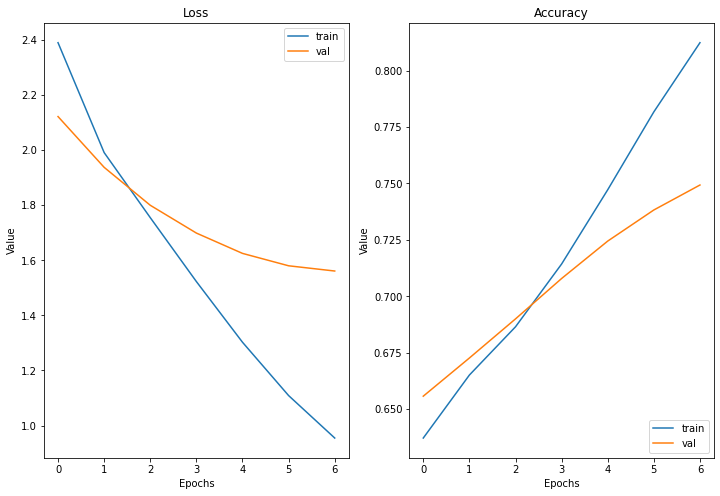

In [ ]:
def plot_curve(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2,figsize = (12, 8))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                if n == 0:
                    ax[i].plot(epochs, y, label="train")
                else:
                    ax[i].plot(epochs, y, label="val")
                ax[i].set_title('Loss')
                ax[i].legend(loc='upper right')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    if n == 2:
                        ax[i].plot(epochs, y, label="train")
                    else:
                        ax[i].plot(epochs, y, label="val")
                    ax[i].set_title('Accuracy')
                    ax[i].legend(loc='lower right')
                    
    plt.show()

plot_curve(history.epoch, history.history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

## STEP 7. 모델 평가

In [ ]:
# 모델에게 시작 문장을 전달하면 모델이 시작 문장을 바탕으로 작문을 진행하게 함
# 초기에 입력문에는 <start> 단어 하나만 넘김.

def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):

    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환하고 엔드토큰 만듬
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 첫번째 루프에서 test_tensor에 <start> 하나가 들어감
        # 모델이 7001개 중 A를 고른다고 하면 
        # 두번째 루프에는 test_tensor에 <start> A 가 들어감
        # 모델이 B를 고름
        # 세번째 루프에는 <start> A B 가 들어감....
        
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [ ]:
# 문장 생성 함수 실행해 봄
# 초기에 <start> he 로 시작하게 넘겨줌
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you , i m not gonna crack <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> My name", max_len=20)

'<start> my name is prince <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> My soul", max_len=20)

'<start> my soul is there <end> '

초기 2번의 시도에서는 오류가 나지는 않았으나 validation loss값이 너무 커서<br>
평가를 하지 않았고,

3, 4번째 시도에서는 val_loss가 어느 정도 낮아져서 테스트 생성을 했는데 <br>
긴 문장이 만들어지지 않았다. 15 단어 이하로만 corpus를 구성하는 코드에서<br>
문제가 있었음을 발견했다.

5번째 시도에서 val_loss가 2.2 이하로 떨어졌고 문장 생성 테스트를 한 결과<br>
이번에는 장문의 문장이 생성되었으나 문맥상 의미가 통하는 문장은 아니었다.

max_len : 15, embedding_size : 128, hidden_size : 512, epoch : 10, 
Epoch 10/10<br>
487/487 [==============================] - 144s 296ms/step - <br>
loss: 0.9885 - accuracy: 0.8096 - <br>
val_loss: 2.1481 - val_accuracy: 0.6740

##### 문장 생성 함수 실행해 봄
init_sentence="<start> i love", max_len=15
=> <start>i love reeboks nebraska nebraska dreamless lasi sposed clue depot lined lined flow flow <end> <br>



## [ 루브릭 ]
### 1. 가사 텍스트 생성 모델이 정상적으로 동작하는가?
##### * 텍스트 제너레이션 결과가 그럴듯한 문장으로 생성되는가?

### 2. 데이터의 전처리와 데이터셋 구성 과정이 체계적으로 진행되었는가?
##### * 특수문자 제거, 토크나이저 생성, 패딩처리 등의 과정이 빠짐없이 진행되었는가?

### 3. 텍스트 생성모델이 안정적으로 학습되었는가? 
##### * 텍스트 생성모델의 validation loss가 2.2 이하로 낮아졌는가?
---

## [ 회고 ]

* 초기 2번의 시도에서는 오류가 나지는 않았으나 validation loss값이 너무 커서
평가를 하지 않았고,

* 3, 4번째 시도에서는 val_loss가 어느 정도 낮아져서 테스트 생성을 했는데
긴 문장이 만들어지지 않았다. 15 단어 이하로만 corpus를 구성하는 코드에서
문제가 있었음을 발견했다.

* 5번째 시도에서 val_loss가 2.2 이하로 떨어졌고 문장 생성 테스트를 한 결과
이번에는 장문의 문장이 생성되었으나 문맥상 의미가 통하는 문장은 아니었다.

  * max_len : 15, embedding_size : 128, hidden_size : 512, epoch : 10, Epoch 10/10
487/487 [==============================] - 144s 296ms/step -<br>
loss: 0.9885 - accuracy: 0.8096 -
val_loss: 2.1481 - val_accuracy: 0.6740

  * 문장 생성 함수 실행해 봄
init_sentence=" i love", max_len=15 => i love reeboks nebraska nebraska dreamless lasi sposed clue depot lined lined flow flow

* Final : max_len을 20으로 조정, epoch는 앞선 학습률 보고 7로 줄임
  * val_loss: 1.5609 - val_accuracy: 0.7493
  * 문장 생성은 충분히 길진 않으나 의미는 통하는 문장이 생성됨.

=> 적절한 하이퍼 파라미터의 설정 기준은 무엇일까? <br>
공식적으로 설정할 수 있는 어떤 기준은 있을 것인데 아직 그런 기준에 대한 이해가 부족한 점이 많다고 느낌. 


---
